## Import Library

In [28]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [29]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [30]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

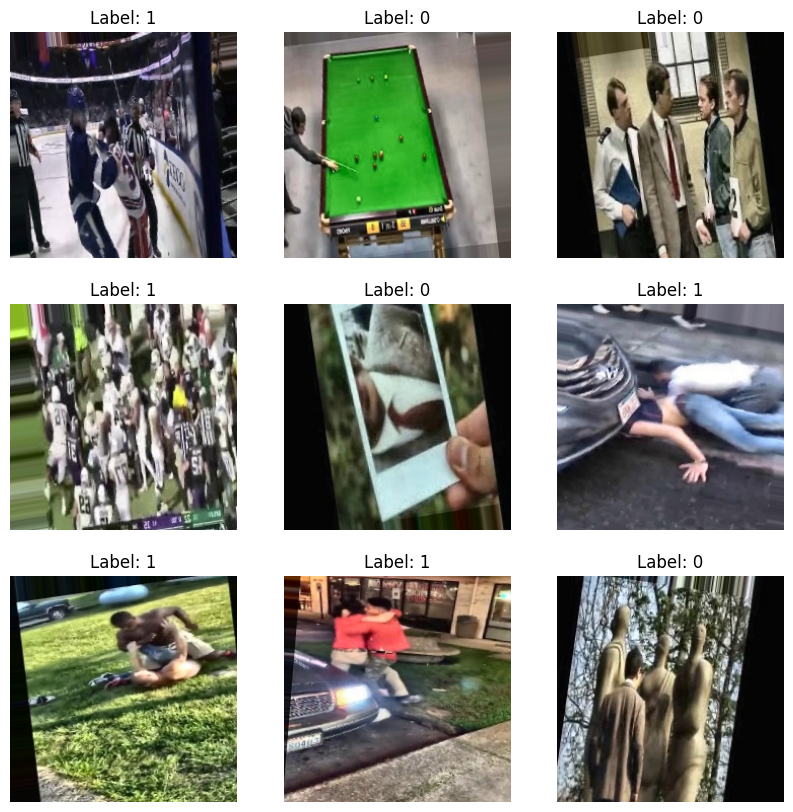

In [31]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [32]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_FreezeAll_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [33]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6883 - loss: 1.1777
Epoch 1: val_accuracy improved from -inf to 0.50455, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.6893 - loss: 1.1745 - val_accuracy: 0.5045 - val_loss: 1.0465
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8274 - loss: 0.7522
Epoch 2: val_accuracy improved from 0.50455 to 0.67955, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.8275 - loss: 0.7517 - val_accuracy: 0.6795 - val_loss: 0.8360
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8668 - loss: 0.6637
Epoch 3: val_accuracy improved from 0.67955 to 0.83636, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.8667 - loss: 0.6636 - val_accuracy: 0.8364 - val_loss: 0.7094
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8944 - loss: 0.5886
Epoch 4: val_accuracy improved from 0.83636 to 0.84773, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.8941 - loss: 0.5890 - val_accuracy: 0.8477 - val_loss: 0.6632
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8823 - loss: 0.5600
Epoch 5: val_accuracy improved from 0.84773 to 0.86591, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 556ms/step - accuracy: 0.8823 - loss: 0.5600 - val_accuracy: 0.8659 - val_loss: 0.6097
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8908 - loss: 0.5396
Epoch 6: val_accuracy improved from 0.86591 to 0.90682, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.8909 - loss: 0.5394 - val_accuracy: 0.9068 - val_loss: 0.5249
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8661 - loss: 0.5445
Epoch 7: val_accuracy improved from 0.90682 to 0.90909, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.8663 - loss: 0.5442 - val_accuracy: 0.9091 - val_loss: 0.5033
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8881 - loss: 0.5125
Epoch 8: val_accuracy improved from 0.90909 to 0.91136, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 544ms/step - accuracy: 0.8882 - loss: 0.5127 - val_accuracy: 0.9114 - val_loss: 0.4878
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9039 - loss: 0.4781
Epoch 9: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step - accuracy: 0.9038 - loss: 0.4783 - val_accuracy: 0.8614 - val_loss: 0.5906
Epoch 10/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9037 - loss: 0.4686
Epoch 10: val_accuracy improved from 0.91136 to 0.92727, saving model to MCLAHE_FreezeAll_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 534ms/step - accuracy: 0.9036 - loss: 0.4689 - val_accuracy: 0.9273 - val_loss: 0.4319
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9125 - loss: 0.4656
Epoch 11: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 533ms/step - accuracy: 0.9124 - loss: 0.4659 - val_accuracy: 0.9023 - val_loss: 0.4832
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8887 - loss: 0.5033
Epoch 12: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.8887 - loss: 0.5032 - val_accuracy: 0.9068 - val_loss: 0.4641
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9120 - loss: 0.4488
Epoch 13: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.9118 - loss: 0.4493 - val_accuracy: 0.9136 - val_loss: 0.4441
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9120 - loss: 0.4477
Epoch 14: val_accuracy i

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 580ms/step - accuracy: 0.9119 - loss: 0.4477 - val_accuracy: 0.9318 - val_loss: 0.4561
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9258 - loss: 0.4092
Epoch 15: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.9255 - loss: 0.4098 - val_accuracy: 0.9250 - val_loss: 0.4052
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9015 - loss: 0.4574
Epoch 16: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.9015 - loss: 0.4574 - val_accuracy: 0.9159 - val_loss: 0.4372
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9226 - loss: 0.4194
Epoch 17: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.9225 - loss: 0.4194 - val_accuracy: 0.9159 - val_loss: 0.4279
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9200 - loss: 0.4295
Epoch 18: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9214 - loss: 0.3238
Validation Loss: 0.35192546248435974
Validation Accuracy: 0.9113636612892151


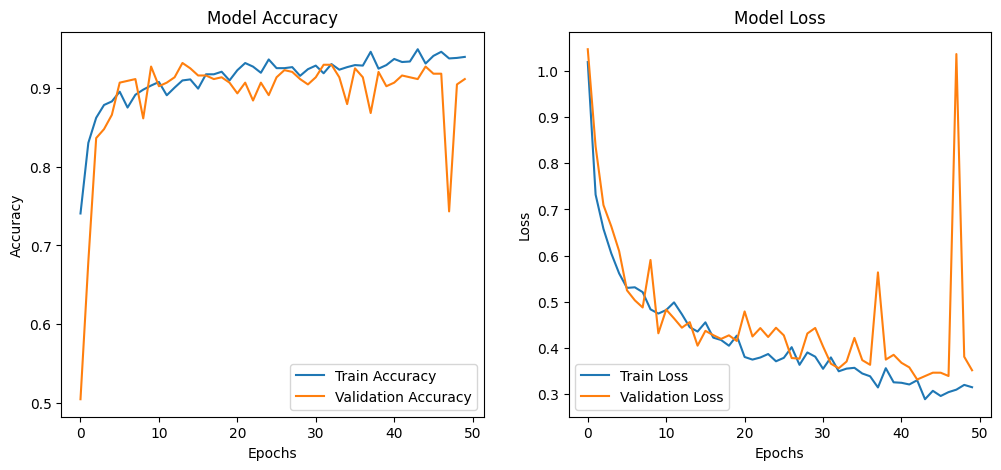

In [34]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [35]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_FreezeAll_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.8154 - loss: 0.7104
Test Accuracy : 88.29%
Test Loss     : 0.555


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step


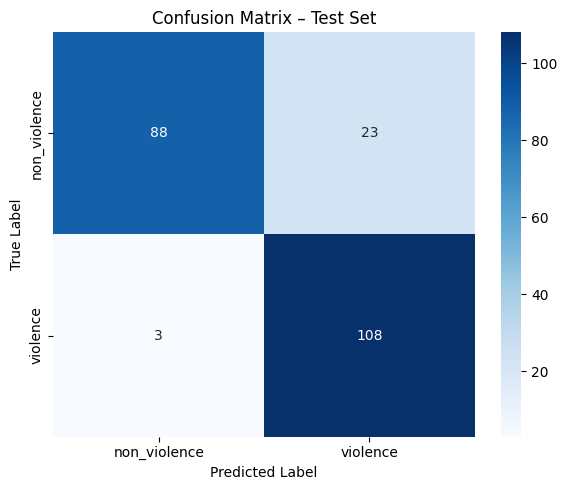


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.97      0.79      0.87       111
    violence       0.82      0.97      0.89       111

    accuracy                           0.88       222
   macro avg       0.90      0.88      0.88       222
weighted avg       0.90      0.88      0.88       222



In [36]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))